In [1]:
from xgboost import XGBClassifier

import sys
from pathlib import Path
import pandas as pd 
import numpy as np
sys.path.append(str(Path("../..").resolve()))
from src.constants import model_data_dir
from src.utils import combine_classes,  use_target, split_folds, BlockingTimeSeriesSplit
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.rcParams['figure.figsize'] = [8, 10]

In [2]:
df_train = pd.read_csv(model_data_dir / "train_classification.csv")
df_test = pd.read_csv(model_data_dir / "test_classification.csv")
test_dates = pd.to_datetime(df_test["date"])
df_train = df_train.drop(columns=["date"])
df_test = df_test.drop("date", axis=1)
df_train = pd.get_dummies(df_train.astype({
    "month": "category",
    "weekday": "category",
    "day": "category",
}), drop_first=True)
df_test = pd.get_dummies(df_test.astype({
    "month": "category",
    "weekday": "category",
    "day": "category",
}), drop_first=True)

## xgboost setup

In [5]:
params = {
    "eta": 0.3,
    "gamma": 1,
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "error",
}

space = {
        'max_depth': 2,
        'gamma': hp.uniform('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 100, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.2, 0.5),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 3, 1),
        "n_jobs": -1,
        "seed": 42,
        "eval_metric": "error"
}

## Size

In [4]:
y_train_size, x_train_size = use_target(df_train, "sc_1d_fwd_rel_d", "classification", next_day=True)
y_test_size, x_test_size = use_target(df_test, "sc_1d_fwd_rel_d", "classification", next_day=True)

# cv_indices = list(split_folds(x_train_size, n_folds=5))

In [61]:
def hyperparameter_tuning(space):
        dtrain = xgb.DMatrix(x_train_size, label=y_train_size)
        dvalid = xgb.DMatrix(x_test_size, label=y_test_size)
        watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
        
        model = xgb.train(
                space, 
                dtrain, 
                evals=watchlist,
                num_boost_round=1000
        )

        pred = model.predict(dvalid)
        accuracy = accuracy_score(y_test_size, pred > 0.5)
        print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [62]:
trials = Trials()
best = fmin(fn= hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

[22:27:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-error:0.51141	train-error:0.47365             
[1]	eval-error:0.51141	train-error:0.47365             
[2]	eval-error:0.51141	train-error:0.47365             
[3]	eval-error:0.51141	train-error:0.47365             
[4]	eval-error:0.51141	train-error:0.47365             
[5]	eval-error:0.51141	train-error:0.47365             
[6]	eval-error:0.51141	train-error:0.47365             
[7]	eval-error:0.51141	train-error:0.47365             
[8]	eval-error:0.51141	train-error:0.47365             
[9]	eval-error:0.511

In [23]:
from sklearn.model_selection import train_test_split

0       1.0
1       1.0
2       0.0
3       1.0
4       0.0
       ... 
3373    0.0
3374    0.0
3375    0.0
3376    0.0
3377    0.0
Name: sc_1d_fwd_rel_d_next, Length: 3378, dtype: float64

In [5]:
# res = xgb.cv(
#         params, 
#         xgb.DMatrix(data = x_train_size, label = y_train_size),
#         folds=cv_indices, 
#         as_pandas = True
# )

grid_search =

In [12]:
res

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.370403,0.010680,0.483259,0.008027
1,0.320385,0.007855,0.483852,0.011650
2,0.289012,0.019271,0.492444,0.009987
3,0.267333,0.014417,0.493333,0.012915
4,0.239660,0.007474,0.486222,0.016049
5,0.219904,0.003314,0.488889,0.014394
6,0.205845,0.005614,0.484444,0.014485
7,0.198742,0.005348,0.482667,0.020213
8,0.183944,0.006499,0.480889,0.013138
9,0.165668,0.014998,0.490074,0.013623


In [93]:
np.mean(xgb_classifier_size.predict(x_test_size) == y_test_size)

0.5124668435013262

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

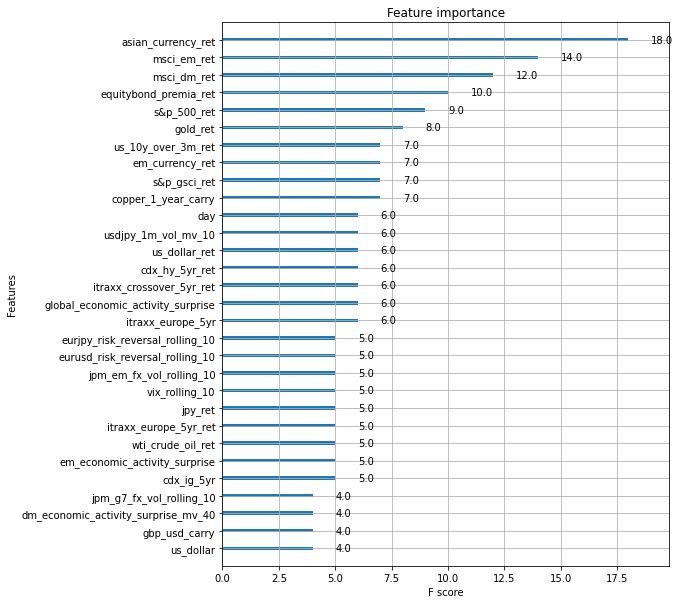

In [94]:
plot_importance(xgb_classifier_size, max_num_features=30)

## Momentum 

In [95]:
xgb_classifier_mom = XGBClassifier(early_stopping_rounds=10, n_estimators=1000, learning_rate=0.1, alpha=1)

In [96]:
y_train_mom, x_train_mom = use_target(df_train, "mom_1d_fwd_rel_d", "classification", next_day=True)
y_test_mom, x_test_mom = use_target(df_test, "mom_1d_fwd_rel_d", "classification", next_day=True)

In [97]:
xgb_classifier_mom.fit(
        x_train_mom, 
        y_train_mom,
        eval_set=[ (x_test_mom, y_test_mom)]
)

[0]	validation_0-logloss:0.69207
[1]	validation_0-logloss:0.69098
[2]	validation_0-logloss:0.69078
[3]	validation_0-logloss:0.69132
[4]	validation_0-logloss:0.69274
[5]	validation_0-logloss:0.69241
[6]	validation_0-logloss:0.69062
[7]	validation_0-logloss:0.69065
[8]	validation_0-logloss:0.69073
[9]	validation_0-logloss:0.69137
[10]	validation_0-logloss:0.69201
[11]	validation_0-logloss:0.69252
[12]	validation_0-logloss:0.69379
[13]	validation_0-logloss:0.69431
[14]	validation_0-logloss:0.69295
[15]	validation_0-logloss:0.69317


XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1, ...)

In [98]:
np.mean(xgb_classifier_mom.predict(x_test_mom) == y_test_mom)

0.53315649867374

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

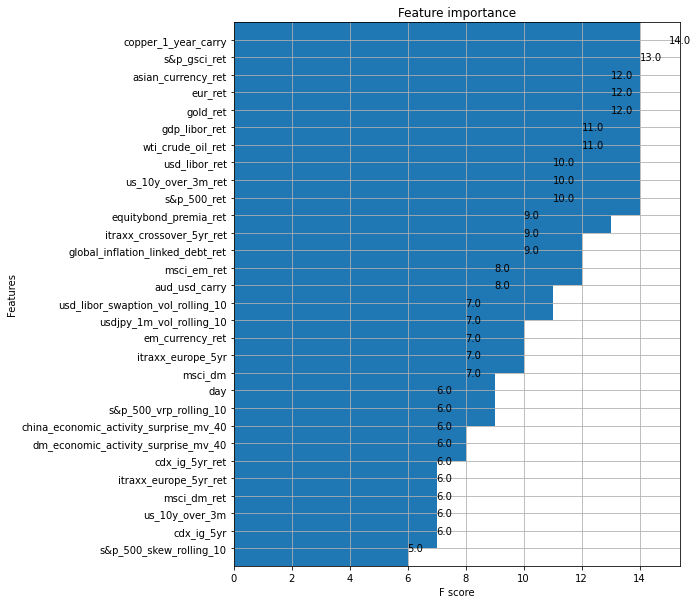

In [99]:


plot_importance(xgb_classifier_mom, height = 20, max_num_features=30)

## Value

In [100]:
xgb_classifier_value = XGBClassifier(early_stopping_rounds=10, n_estimators=1000, learning_rate=0.1, alpha=1)

In [101]:
y_train_value, x_train_value = use_target(df_train, "value_1d_fwd_rel_d", "classification")
y_test_value, x_test_value = use_target(df_test, "value_1d_fwd_rel_d", "classification")

In [102]:
xgb_classifier_value.fit(
        x_train_value, 
        y_train_value,
        eval_set=[ (x_test_value, y_test_value)]
)

[0]	validation_0-logloss:0.69513
[1]	validation_0-logloss:0.69667
[2]	validation_0-logloss:0.69754
[3]	validation_0-logloss:0.69948
[4]	validation_0-logloss:0.70020
[5]	validation_0-logloss:0.70178
[6]	validation_0-logloss:0.70327
[7]	validation_0-logloss:0.70353
[8]	validation_0-logloss:0.70431
[9]	validation_0-logloss:0.70460


XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1, ...)

In [103]:
np.mean(xgb_classifier_value.predict(x_test_value) == y_test_value)

0.4931071049840933

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

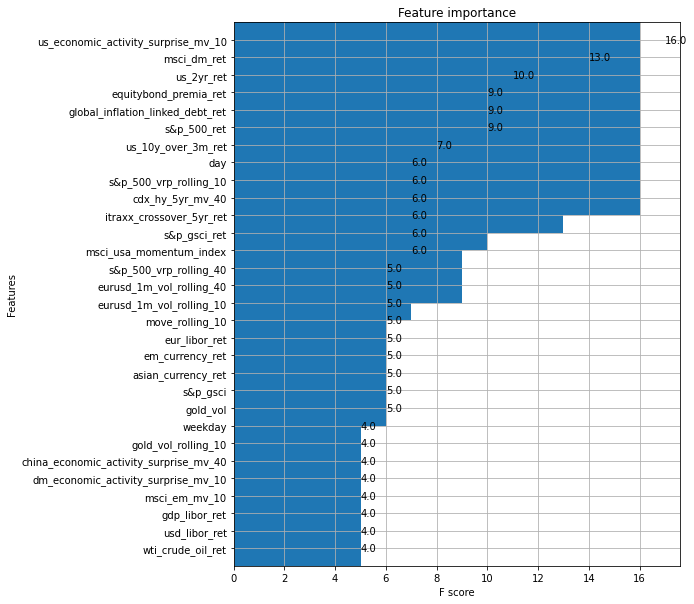

In [104]:
plot_importance(xgb_classifier_value, height = 20, max_num_features=30)

In [105]:
from sklearn.feature_selection import SelectFromModel

value_selection = SelectFromModel(xgb_classifier_value, max_features=30, prefit=True)
xgb_classifier_value.feature_names_in_[value_selection.get_support()]

array(['jpm_em_fx_vol', 's&p_500_vrp', 'us_10y_over_3m',
       'gtcad10yr_corp_', 'eur_libor', 'iwf', 'msci_usa_momentum_index',
       'msci_usa_enhanced_value_index', 's&p_500_ret', 'msci_em_ret',
       'move_mv_40', 'usdjpy_1m_vol_mv_10', 's&p_500_vrp_mv_40',
       'msci_em_mv_10', 'itraxx_crossover_5yr_mv_10', 'cdx_ig_5yr_mv_40',
       'cdx_hy_5yr_mv_40', 'gtcad3mo_corp_mv_40', 'gtfrf10yr_corp_mv_10',
       'gtdem10yr_corp_mv_10', 'gtdem3mo_corp_mv_40',
       'em_economic_activity_surprise_mv_40',
       'us_economic_activity_surprise_mv_10',
       'us_monetary_policy_uncertainty_mv_40',
       'university_of_michigan_consumer_sentiment_mv_10', 'iwm_mv_10',
       'msci_usa_enhanced_value_index_mv_10', 'jpy_usd_carry_mv_40',
       'jpm_g7_fx_vol_rolling_10', 'eurjpy_risk_reversal_rolling_40'],
      dtype='<U47')